## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import time

%matplotlib inline

In [12]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

In [13]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torchsummary
from torch.utils.data import TensorDataset, DataLoader

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

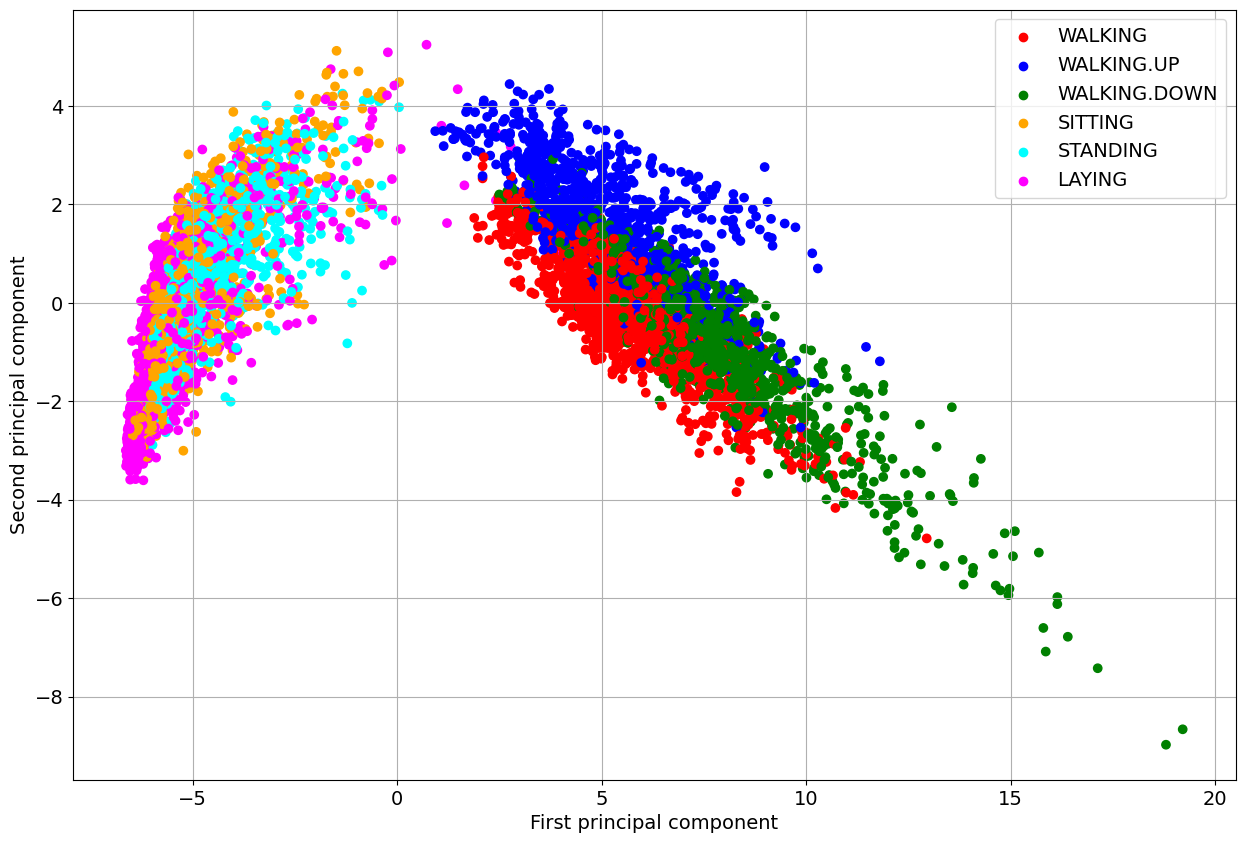

In [43]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [44]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [45]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

# Data Loaders

In [46]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [47]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [48]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [49]:
train_iter = iter(train_dataloader)
print(type(train_iter))

images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
images shape on batch size = torch.Size([128, 128, 9])
labels shape on batch size = torch.Size([128, 1])


# GPU

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# Train

In [51]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    # Инициализация списков для хранения значений потерь и точности на тренировочной и валидационной выборках
    train_loss = []  # Список для хранения среднего значения потерь на тренировочной выборке для каждого эпохи
    val_loss = []  # Список для хранения среднего значения потерь на валидационной выборке для каждой эпохи
    val_accuracy = []  # Список для хранения средней точности на валидационной выборке для каждой эпохи

    # Основной цикл по количеству эпох
    for epoch in range(n_epochs):
        ep_train_loss = []  # Список для хранения потерь на каждой итерации в текущей эпохе для тренировочной выборки
        ep_val_loss = []  # Список для хранения потерь на каждой итерации в текущей эпохе для валидационной выборки
        ep_val_accuracy = []  # Список для хранения точности на каждой итерации для валидационной выборки
        start_time = time.time()  # Запись времени начала эпохи для подсчета времени выполнения

        # Установка режима обучения для модели (активируются такие механизмы, как Dropout и BatchNorm)
        model.train(True)
        
        # Цикл по батчам тренировочной выборки
        for X_batch, y_batch in train_loader:
            opt.zero_grad()  # Обнуление градиентов перед обратным проходом

            X_batch = X_batch.to(device)  # Перенос входных данных на устройство (GPU или CPU)
            y_batch = y_batch.to(device)  # Перенос меток (labels) на устройство

            predictions = model(X_batch)  # Прогон входных данных через модель, получение предсказаний
            loss = loss_fn(predictions, y_batch.squeeze(1))  # Подсчет потерь (loss) между предсказаниями и реальными метками
            loss.backward()  # Обратное распространение ошибки (backpropagation) для подсчета градиентов
            opt.step()  # Обновление параметров модели на основе вычисленных градиентов

            ep_train_loss.append(loss.item())  # Сохранение значения потерь для текущей итерации

        # Установка модели в режим оценки (выключение Dropout и BatchNorm)
        model.train(False)
        
        # Отключение градиентов для уменьшения нагрузки на память и ускорения вычислений
        with torch.no_grad():
            # Цикл по батчам валидационной выборки
            for X_batch, y_batch in val_loader:

                X_batch = X_batch.to(device)  # Перенос входных данных на устройство (GPU или CPU)
                y_batch = y_batch.to(device)  # Перенос меток (labels) на устройство

                predictions = model(X_batch)  # Прогон входных данных через модель, получение предсказаний
                loss = loss_fn(predictions, y_batch.squeeze(1))  # Подсчет потерь (loss) между предсказаниями и реальными метками

                ep_val_loss.append(loss.item())  # Сохранение значения потерь для текущей итерации
                y_pred = predictions.max(1)[1].data  # Определение метки класса с максимальной вероятностью
                ep_val_accuracy.append(np.mean((y_batch.squeeze(1).cpu() == y_pred.cpu()).numpy()))  # Подсчет точности предсказания для текущего батча

        # Вывод информации о текущей эпохе и времени выполнения
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        # Подсчет среднего значения потерь и точности для текущей эпохи
        train_loss.append(np.mean(ep_train_loss))  # Средняя потеря по всем батчам для тренировочной выборки
        val_loss.append(np.mean(ep_val_loss))  # Средняя потеря по всем батчам для валидационной выборки
        val_accuracy.append(np.mean(ep_val_accuracy))  # Средняя точность по всем батчам для валидационной выборки

    # Возвращение списков с потерями и точностью для каждой эпохи
    return train_loss, val_loss, val_accuracy


In [52]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    # Создание графиков с двумя подграфиками (1 строка, 2 столбца) и размером фигуры 15x5
    fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

    # Настройка первого графика — отображение потерь (loss)
    axes[0].set_title('Loss')  # Установка заголовка графика
    axes[0].plot(train_loss, label='train')  # Отображение графика потерь на тренировочной выборке
    axes[0].plot(val_loss, label='validation')  # Отображение графика потерь на валидационной выборке
    axes[0].legend()  # Добавление легенды для обозначения линий (train и validation)

    # Настройка второго графика — отображение точности (accuracy) на валидационной выборке
    axes[1].set_title('Validation accuracy')  # Установка заголовка графика
    axes[1].plot(val_accuracy)  # Отображение графика точности на валидационной выборке


In [53]:
# Определение размеров входа и количества классов
input_shape = 128 * 9  # Входное количество признаков (может быть, например, развернутая матрица 128x9)
num_classes = 6  # Количество классов для предсказания (целевые метки от 0 до 5, если классы нумеруются с нуля)

# Определение архитектуры модели с использованием nn.Sequential
model = nn.Sequential(
    nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=9, stride=1, padding=0), 
    # 1D-сверточный слой (Conv1d) с 128 входными каналами, 1024 выходными каналами, размером фильтра 9 и шагом 1
    nn.BatchNorm1d(1024),  # Нормализация (Batch Normalization) для ускорения обучения и уменьшения переобучения
    nn.LeakyReLU(),  # Активирующая функция Leaky ReLU для добавления нелинейности
    nn.Flatten(),  # Преобразование многомерного тензора в одномерный для передачи в полносвязные слои
    nn.Dropout(0.7),  # Dropout с вероятностью 0.7 для предотвращения переобучения
    nn.Linear(1024, 512),  # Полносвязный слой (Linear) с 1024 входами и 512 выходами
    nn.BatchNorm1d(512),  # Нормализация (Batch Normalization) для ускорения обучения
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Dropout(0.7),  # Dropout с вероятностью 0.7 для предотвращения переобучения
    nn.Linear(512, 256),  # Полносвязный слой (Linear) с 512 входами и 256 выходами
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Dropout(0.7),  # Dropout с вероятностью 0.7 для предотвращения переобучения
    nn.Linear(256, 64),  # Полносвязный слой (Linear) с 256 входами и 64 выходами
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Linear(64, 32),  # Полносвязный слой (Linear) с 64 входами и 32 выходами
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Linear(32, 12),  # Полносвязный слой (Linear) с 32 входами и 12 выходами
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Linear(12, num_classes),  # Полносвязный слой (Linear) с 12 входами и количеством выходов, равным числу классов
    nn.LogSoftmax(dim=1)  # LogSoftmax для получения логарифма вероятностей классов по выходам сети
)

# Отправка модели на устройство (GPU или CPU) и указание типа данных (float32)
model.to(device, torch.float32)  

# Оптимизатор Adam для обновления параметров модели
opt = torch.optim.Adam(model.parameters(), lr=1e-3)  
# Параметры модели передаются оптимизатору, а также устанавливается начальная скорость обучения (learning rate)

# Функция потерь — отрицательный логарифм правдоподобия (NLLLoss) для многоклассовой классификации
loss_func = nn.NLLLoss()  
# NLLLoss ожидает логарифмированные вероятности на выходе (поэтому используется nn.LogSoftmax в конце модели)

In [54]:
n_epochs = 100

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

Epoch 1 of 100 took 5.502s
Epoch 2 of 100 took 5.365s
Epoch 3 of 100 took 5.626s
Epoch 4 of 100 took 5.500s


KeyboardInterrupt: 

accuracy:  0.9287109375


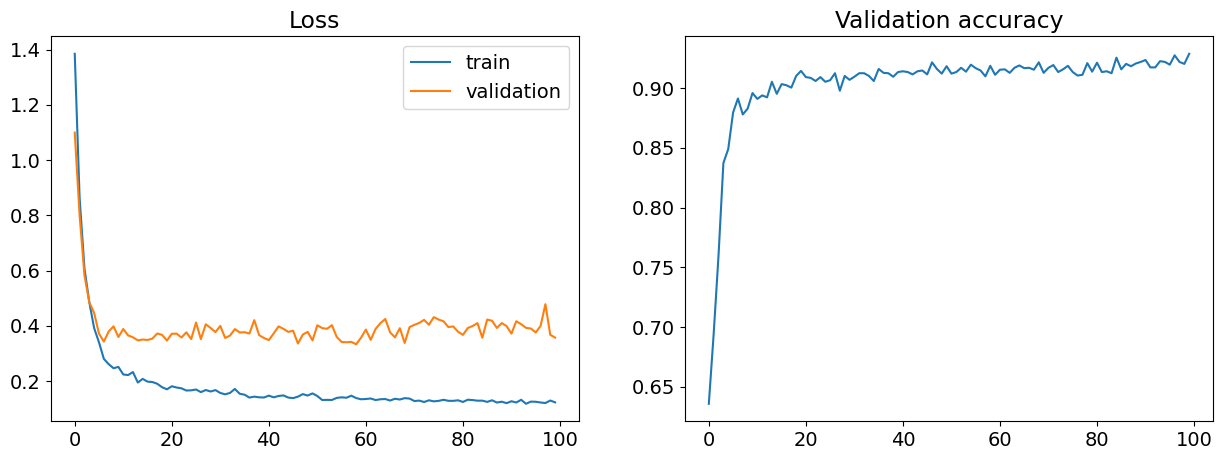

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)
print("accuracy: ", val_accuracy[-1])

Выбор архитектуры модели

Входные данные: Входной размер 128 x 9 был преобразован в одномерный вектор для удобства обработки с помощью сверточных и полносвязных слоев.

Сверточный слой (Conv1d):

Почему Conv1d? Данные представляются в виде одномерных последовательностей, и сверточные слои Conv1d эффективно извлекают локальные зависимости.
Параметры Conv1d:
in_channels=128 — количество входных каналов соответствует количеству признаков во входных данных.
out_channels=1024 — количество фильтров, увеличивающее объем представления данных.
kernel_size=9 — размер фильтра, охватывающий все 9 элементов, что позволяет учитывать зависимости по всей ширине вектора.
stride=1, padding=0 — стандартные значения для уверенного извлечения признаков.
Batch Normalization:

Почему BatchNorm1d? Нормализация входных данных на каждом слое ускоряет обучение и предотвращает переобучение.
Где используется? После каждого сверточного и полносвязного слоя для стабилизации градиентов.
Функция активации (LeakyReLU):

Почему LeakyReLU? В отличие от обычной ReLU, LeakyReLU пропускает небольшие отрицательные значения, что снижает риск возникновения "мертвых нейронов" и улучшает обучение.
Где используется? После каждого сверточного и полносвязного слоя.
Полносвязные слои (Linear):

Почему используются Linear-слои? После сверточного слоя необходимо преобразовать многомерные признаки в одномерный вектор для классификации.
Структура сети:
Сначала 1024 → 512 → 256 → 64 → 32 → 12 → 6 (где 6 — количество классов).
Снижение размерности (разреженная сеть) помогает минимизировать переобучение и улучшает обобщающую способность модели.
Dropout:

Почему Dropout? Dropout используется для случайного обнуления части нейронов с вероятностью 0.7 для борьбы с переобучением.
Где используется? После основных полносвязных слоев для регуляризации и уменьшения переобучения.
Выходной слой:

Почему LogSoftmax? Для работы с функцией потерь NLLLoss требуется, чтобы выходы были логарифмированными вероятностями.
Почему 6 выходов? Потому что задача — классификация на 6 классов, и выходная размерность соответствует количеству классов.
Оптимизатор и функции потерь

Оптимизатор Adam:

Почему Adam? Этот оптимизатор адаптивно подбирает скорость обучения для каждого параметра, что ускоряет сходимость.
Начальная скорость обучения (learning rate = 1e-3) — выбрано эмпирически как стандартное значение для многих задач.
Функция потерь NLLLoss:

Почему NLLLoss? Поскольку последний слой использует LogSoftmax, наиболее подходящей функцией потерь является NLLLoss, которая работает с логарифмом вероятностей.
Почему именно NLLLoss, а не CrossEntropyLoss? CrossEntropyLoss объединяет Softmax и NLLLoss, но так как мы отдельно используем LogSoftmax, то NLLLoss — правильный выбор.
Преимущества выбранного подхода

Устойчивость к переобучению:

Использование Dropout и Batch Normalization делает сеть устойчивой к переобучению.
Эффективность и скорость сходимости:

LeakyReLU устраняет проблему "мертвых нейронов", делая обучение более устойчивым.
Adam ускоряет обучение за счет адаптивной скорости обучения для каждого параметра.
Гибкость и масштабируемость:

Архитектура легко расширяется под другие задачи классификации (достаточно изменить размер выходного слоя и число классов).
Использование стандартных подходов (BatchNorm, Dropout) делает обучение стабильным и переносимым на другие наборы данных.
Возможные улучшения
Добавить scheduler — использование scheduler для адаптивного изменения скорости обучения. Например, можно уменьшать learning rate каждые 10 эпох.
Провести кросс-валидацию — для оценки устойчивости модели на различных подвыборках данных.
Увеличить количество фильтров в сверточных слоях для извлечения большего количества признаков.
Добавить больше регуляризации — можно уменьшить p в Dropout, чтобы меньше нейронов обнулялось.

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [14]:
# Your experiments here
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import time

%matplotlib inline
import matplotlib

import torch, torch.nn as nn
import torch.nn.functional as F
import torchsummary
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, TensorDataset, DataLoader, SubsetRandomSampler
from torch import Tensor
from PIL import Image
import os
from skimage import io, transform

# Dogs data

In [15]:
train_folders = 'data/train/'
test_folders = 'data/test/'

In [16]:
classes = []
for c in range(50):
    for _ in os.listdir(train_folders + str(c)):
        classes.append(c)

# Transforms

In [17]:
# Трансформации для обучающей выборки
train_transform = transforms.Compose([ 
    transforms.RandomRotation(15),  
    # Случайное вращение изображения на угол до 15 градусов в любую сторону (влево или вправо), 
    # помогает сделать модель более устойчивой к изменениям ориентации изображений
    
    transforms.RandomResizedCrop(224),  
    # Случайное обрезание изображения до размера 224x224 пикселя с изменением масштаба и пропорций, 
    # что помогает увеличить разнообразие данных и улучшить генерализацию модели
    
    transforms.ToTensor(),  
    # Преобразование изображения из формата PIL (или numpy) в тензор PyTorch, 
    # нормализованный в диапазоне [0, 1]
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    # Нормализация тензора по каналам (RGB) с заданными средними значениями и стандартными отклонениями. 
    # Это делается для того, чтобы привести значения пикселей к стандартному диапазону, что ускоряет обучение.
])

# Трансформации для валидационной выборки
val_transform = transforms.Compose([ 
    transforms.CenterCrop(224),  
    # Обрезка изображения по центру до размера 224x224 пикселя. 
    # В отличие от RandomResizedCrop, эта операция всегда вырезает центральную часть изображения, 
    # что делает оценку на валидационной выборке более стабильной.
    
    transforms.ToTensor(),  
    # Преобразование изображения из формата PIL (или numpy) в тензор PyTorch, 
    # нормализованный в диапазоне [0, 1]
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    # Нормализация тензора по каналам (RGB) с заданными средними значениями и стандартными отклонениями.
    # Значения средних и стандартных отклонений взяты из предобученных моделей ImageNet.
])

In [18]:
# Загрузка обучающих и валидационных данных из папок с изображениями
train_data = torchvision.datasets.ImageFolder(
    root=train_folders,  # Путь к папке с изображениями для обучения
    transform=train_transform  # Применение набора аугментаций и преобразований к изображениям для обучения
)

val_data = torchvision.datasets.ImageFolder(
    root=train_folders,  # Путь к папке с изображениями для валидации (обычно это та же папка, что и для train)
    transform=val_transform  # Применение преобразований, специфичных для валидационной выборки
)

# Подготовка индексов для разделения данных на обучающую и валидационную выборки
N = len(classes)  # Общее количество классов (предполагается, что классы представлены папками)
indices = list(range(N))  # Список индексов от 0 до N-1
split = int(0.2 * N)  # Определяем, сколько данных пойдёт в валидационную выборку (20% от всех данных)
np.random.shuffle(indices)  # Перемешиваем индексы для случайного разделения данных на train и val

# Разделение индексов на обучающую и валидационную части
train_idx, val_idx = indices[split:], indices[:split]  
# Первые 20% (val) идут в валидационную часть, а остальные 80% (train) — в обучающую часть

# Подготовка случайных семплеров для обучения и валидации
train_sampler = SubsetRandomSampler(train_idx)  # Сэмплер для случайного извлечения изображений из обучающей выборки
val_sampler = SubsetRandomSampler(val_idx)  # Сэмплер для случайного извлечения изображений из валидационной выборки

# Загрузка обучающих данных в DataLoader
train_loader = torch.utils.data.DataLoader(
    train_data,  # Датасет для обучения
    batch_size=128,  # Размер батча (количество изображений в каждом батче)
    sampler=train_sampler,  # Сэмплер для случайного извлечения данных из обучающей выборки
    num_workers=4  # Количество потоков для параллельной загрузки данных (ускоряет загрузку)
)

# Загрузка валидационных данных в DataLoader
val_loader = torch.utils.data.DataLoader(
    val_data,  # Датасет для валидации
    batch_size=128,  # Размер батча для валидации
    sampler=val_sampler,  # Сэмплер для случайного извлечения данных из валидационной выборки
    num_workers=4  # Количество потоков для параллельной загрузки данных
)

# ResNet101

In [19]:
# Переменная, которая определяет, будет ли извлечение признаков (feature extraction) или полное обучение модели
feature_extract = True  # Если True, то слои модели будут "заморожены", и обучение будет происходить только на последних слоях

# Количество классов, которые нужно предсказать
num_classes = 50  # Количество классов в задаче классификации (например, 50 уникальных классов изображений)

# Загрузка предобученной модели ResNet101
model = models.resnet101(pretrained=True)  # Загрузка предобученной модели ResNet101 с весами ImageNet

# Вывод списка всех слоев модели (имя слоя и его содержимое)
print("layers:", [name for name, child in model.named_children()])  
# Перебор всех слоев модели и отображение их имён, чтобы понять структуру и иерархию слоев


layers: ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


# Freeze layers

In [20]:
# Цикл по всем слоям модели ResNet101
for name, child in model.named_children():  # Итерируемся по всем дочерним слоям модели
    if name in ['fc']:  # Проверяем, является ли текущий слой полносвязным слоем (fc)
        print(name + ' is unfrozen')  # Выводим сообщение о том, что слой "разморожен" (будет обучаться)
        for param in child.parameters():  # Итерируемся по параметрам данного слоя
            param.requires_grad = True  # Устанавливаем requires_grad=True, что позволяет изменять веса этого слоя
    else:  # Для всех остальных слоев (conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool)
        print(name + ' is frozen')  # Выводим сообщение о том, что слой "заморожен" (веса не будут изменяться)
        for param in child.parameters():  # Итерируемся по параметрам данного слоя
            param.requires_grad = False  # Замораживаем веса слоя (градиенты не будут вычисляться)


conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is frozen
avgpool is frozen
fc is unfrozen


In [21]:
# Количество входных признаков для последнего слоя ResNet101 (fc)
in_features = model.fc.in_features  # Получение количества входных признаков последнего слоя модели ResNet101

# Количество скрытых нейронов в новом полносвязном слое
hidden_features = 640  # Количество нейронов в скрытом слое после первого полносвязного слоя

# Замена финального слоя ResNet101 на новый полносвязный слой
model.fc = nn.Sequential(
    nn.Linear(in_features, hidden_features),  # Полносвязный слой, преобразующий in_features в hidden_features
    nn.Dropout(),  # Dropout для регуляризации, который случайно "выключает" нейроны
    nn.BatchNorm1d(hidden_features),  # Нормализация BatchNorm для стабилизации обучения и ускорения сходимости
    nn.LeakyReLU(),  # Функция активации LeakyReLU для добавления нелинейности
    nn.Linear(hidden_features, 50)  # Полносвязный слой для предсказания 50 классов
)

# Размер входных изображений
input_size = 224  # Размер входного изображения (обычно используется 224x224 для ResNet)

# Отправляем модель на устройство (GPU или CPU)
model = model.to(device)  # Отправляем модель на устройство (например, GPU) для ускоренного обучения

# Определение функции потерь
loss_func = nn.CrossEntropyLoss().type(torch.FloatTensor)  
# CrossEntropyLoss — стандартная функция потерь для многоклассовой классификации, 
# она объединяет softmax и negative log likelihood loss (NLLLoss)

# Определение оптимизатора
opt = torch.optim.SGD(
    model.parameters(),  # Параметры модели, которые будут обновляться
    lr=1e-1,  # Скорость обучения (learning rate)
    momentum=0.9,  # Моментум для ускорения градиентного спуска
    nesterov=True  # Включение Nesterov momentum, который является улучшенной версией стандартного momentuma
)

# Определение планировщика изменения скорости обучения (Learning Rate Scheduler)
scheduler = torch.optim.lr_scheduler.StepLR(
    opt,  # Оптимизатор, для которого будет применяться изменение скорости обучения
    step_size=4,  # Каждые 4 эпохи скорость обучения будет изменяться
    gamma=0.8  # Скорость обучения будет умножаться на 0.8 (то есть уменьшаться на 20%)
)


# Train

In [22]:
# Функция для обучения модели
def train_model(model, train_loader, loss_fn, opt, val_loader=None, n_epochs=70, scheduler=None):
    train_loss = []  # Список для хранения потерь на тренировочной выборке
    val_loss = []  # Список для хранения потерь на валидационной выборке
    val_accuracy = []  # Список для хранения точности на валидационной выборке
    
    for epoch in range(n_epochs):  # Цикл по эпохам
        ep_train_loss = []  # Потери на текущей эпохе для тренировочной выборки
        ep_val_loss = []  # Потери на текущей эпохе для валидационной выборки
        ep_val_accuracy = []  # Точность на текущей эпохе для валидационной выборки
        start_time = time.time()  # Начало отсчёта времени выполнения эпохи

        # Устанавливаем модель в режим обучения (включаются Dropout, BatchNorm и т.д.)
        model.train(True)  
        
        # Цикл по батчам из загрузчика тренировочной выборки
        for X_batch, y_batch in train_loader:
            opt.zero_grad()  # Обнуление градиентов перед обратным распространением

            # Перенос данных на устройство (GPU или CPU)
            X_batch = X_batch.to(device)  
            y_batch = y_batch.to(device)  

            # Прямой проход (forward pass)
            prediction = model.forward(X_batch)  
            
            # Подсчёт функции потерь
            loss_value = loss_fn(prediction, y_batch)  

            # Обратное распространение ошибки (backpropagation)
            loss_value.backward()  
            
            # Обновление параметров модели
            opt.step()  

            # Сохранение значения потерь для текущей эпохи
            ep_train_loss.append(loss_value.item())  

        # Устанавливаем модель в режим оценки (выключаются Dropout и BatchNorm)
        model.train(False)  
        
        # Отключаем вычисление градиентов для валидации (ускоряет вычисления)
        with torch.no_grad():
            # Цикл по батчам из загрузчика валидационной выборки
            for X_batch, y_batch in val_loader:
                # Перенос данных на устройство (GPU или CPU)
                X_batch = X_batch.to(device)  
                y_batch = y_batch.to(device)  

                # Прямой проход (forward pass)
                predictions = model.forward(X_batch)  
                
                # Подсчёт функции потерь
                loss_value = loss_fn(predictions, y_batch)  

                # Сохранение значения потерь для текущей эпохи
                ep_val_loss.append(loss_value.item())  

                # Подсчёт предсказаний (берётся индекс максимального значения по последней размерности)
                y_pred = predictions.max(-1).indices  
                
                # Подсчёт точности (количество правильных предсказаний делится на количество всех предсказаний)
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))  

        # Вывод информации об эпохе (время и точность)
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s val acc {np.mean(ep_val_accuracy)}')

        # Сохранение средней потери и точности для текущей эпохи
        train_loss.append(np.mean(ep_train_loss))  # Средняя потеря по батчам обучающей выборки
        val_loss.append(np.mean(ep_val_loss))  # Средняя потеря по батчам валидационной выборки
        val_accuracy.append(np.mean(ep_val_accuracy))  # Средняя точность по батчам валидационной выборки

        # Шаг изменения скорости обучения, если задан scheduler
        if scheduler:
            scheduler.step()  

    # Возвращение значений потерь и точности для каждой эпохи
    return train_loss, val_loss, val_accuracy  


# Функция для построения графиков обучения
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Создание двух подграфиков (1 строка, 2 столбца) с размером фигуры 15x5

    # График потерь
    axes[0].set_title('Loss')  # Установка заголовка графика
    axes[0].plot(train_loss, label='train')  # График потерь на обучающей выборке
    axes[0].plot(val_loss, label='validation')  # График потерь на валидационной выборке
    axes[0].legend()  # Добавление легенды (train и validation)

    # График точности
    axes[1].set_title('Validation accuracy')  # Установка заголовка графика
    axes[1].plot(val_accuracy)  # График точности на валидационной выборке

In [ ]:
n_epochs = 20

train_loss, val_loss, val_accuracy = train_model(model, train_loader, loss_func, opt, val_loader=val_loader, n_epochs=n_epochs, scheduler=None)

Epoch 1 of 4 took 48.348s val acc 0.9091927083333333
Epoch 2 of 4 took 53.574s val acc 0.9125260416666667
Epoch 3 of 4 took 55.555s val acc 0.9198437500000001
Epoch 4 of 4 took 56.585s val acc 0.91375


accuracy:  0.9244791666666666


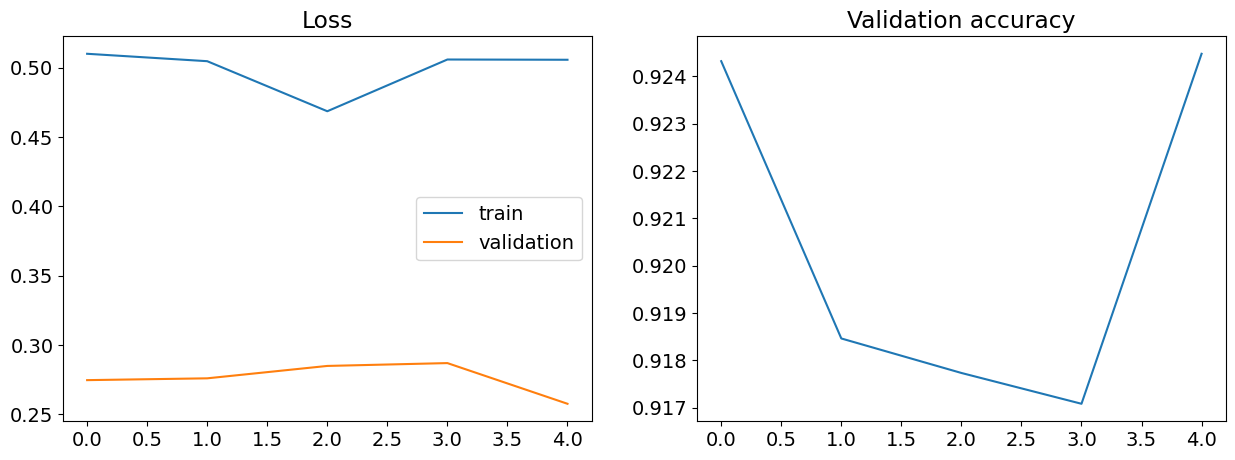

In [68]:
plot_train_process(train_loss, val_loss, val_accuracy)
print("accuracy: ", val_accuracy[-1])

у resnet101самые лучшие результаты поэтому взяли именно ее/

In [1]:
class DogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.len = max(int(file[:-5]) for file in os.listdir(root_dir) if file[:-5].isnumeric()) + 1

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = Image.open(rf"{self.root_dir}/{idx}.jpeg")
        if self.transform:
            image = self.transform(image)
        return image, idx

NameError: name 'Dataset' is not defined

In [ ]:
test_dataset = DogsDataset(root_dir=test_folder, transform=train_transform)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128, 
                                          num_workers=4)
preds = []
idxs = []
model.train(False)
with torch.no_grad():
    for data in test_loader:
        image, idx = data
        image = image.to(device)
        idxs.extend(idx)
        preds.extend(model(image).cpu().detach().numpy().tolist())
idxs_list = [idx.item() for idx in idxs]
preds = np.array(preds)
predictions = pd.DataFrame()
predictions["photo"] = idxs_list
predictions["pred"] = np.argmax(preds, axis=1)

predictions.to_csv("test.csv")